### Watershed Delineation Application Programming Interface (API)
###### Academy of Natural Sciences of Drexel University,  Drexel University College of Computing and Informatics

The Drexel University College of Computing and Informatics (CCI) and the Academy of Natural Sciences (ANS) of Drexel University have developed Application Programming Interfaces (APIs) which incorporate novel algorithms to apply efficient solutions to complex environmental queries. The APIs are built in Python using a GeoDjango Web framework, Nginx, Docker, PostgreSQL, and Swagger.

The Watersheds API utilizes a rapid watershed delineation algorithm for 2D flow direction grids. This API quickly delineates a watershed boundary for any simple geometric object (point, line, or polygon). This algorithm provides geometric speed increases in watershed boundary retrieval while keeping storage constraints linear in comparison to existing techniques. Existing techniques also scale proportionally to the area of the underlying region; however, the complexity of this algorithm is proportional to the boundary length as is relies on a Watershed Marching Algorithm (WMA). (Haag et al. 2018, https://www.sciencedirect.com/science/article/abs/pii/S1364815218303530)

### Fast Zonal Statistics API
###### Academy of Natural Sciences of Drexel University,  Drexel University College of Computing and Informatics

The Fast-Zonal Statistics (FZS) API can return numerical attributes (mean, sum, and count) for a submitted polygon query region over any regular grid or raster dataset. Common applications of this technology include determining the amount of precipitation or impervious surfaces in a watershed. This algorithm is labeled “fast” because to determine the zonal sum for a polygon over a raster surface, only the cells which intersect the boundary of the polygon must be traversed rather than all the interior cells. This means that computationally the approach scales much better with increased data resolution as the FZS algorithm is constant in relation to the length (meters) of the polygon perimeter rather than its area (meters square). (Haag et al. 2020, https://www.sciencedirect.com/science/article/pii/S0098300419306697)

### OSI Spatial Analysis
###### Academy of Natural Sciences of Drexel University,  Drexel University College of Computing and Informatics

The Open Space Institute (OSI) funded the creation of an API in which when given an input a polygon, the amount of stream bank, headwaters, active river area (ARA), wetlands, and all Priority Water Resources (PWR) within are returned.

In [1]:
# nbi:hide_in
from ipyleaflet import Map, basemaps, Polygon, DrawControl, WidgetControl, GeoJSON, MeasureControl
from ipywidgets import IntSlider, ColorPicker, jslink
import requests
import geojson
import json
import shapely
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# nbi:hide_in
# Create the map
# Map centred on Wissahickon Park
displaymap1 = Map(center = (40.050, -75.215), zoom = 12, min_zoom = 1, max_zoom = 20,  scroll_wheel_zoom = True,
    basemap=basemaps.Esri.WorldStreetMap)

# Enable user to draw polygons and lines
draw_control = DrawControl()
draw_control.polyline =  {
    "shapeOptions": {
        "color": "#6bc2e5",
        "weight": 4,
        "opacity": 1.0
    }
}
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 0.3,
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": True,
}

# Save the drawn geometry to a geojson
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    # Save the GeoJSON when it's drawn on the map  
    feature_collection['features'].append(geo_json)

# Add in a zoom slider bar for fun
zoom_slider1 = IntSlider(description='Zoom level:', min=0, max=20, value=12)
jslink((zoom_slider1, 'value'), (displaymap1, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider1, position='topright')

# Add in ability to do measurements
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)

displaymap1.add_control(measure)

measure.completed_color = 'red'

measure.add_length_unit('yards', 1.09361, 4)
measure.secondary_length_unit = 'yards'

measure.add_area_unit('sqyards', 1.19599, 4)
measure.secondary_area_unit = 'sqyards'

# Add everything into the map
draw_control.on_draw(handle_draw)
displaymap1.add_control(draw_control)
displaymap1.add_control(widget_control1)

# Show the map
displaymap1

Map(center=[40.05, -75.215], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [12]:

# Show the last drawn shape
last_geom_idx = len(feature_collection['features']) - 1
last_geom = feature_collection['features'][last_geom_idx]['geometry']
last_geom

{'type': 'Polygon',
 'coordinates': [[[-75.205702, 40.018234],
   [-75.196925, 40.014437],
   [-75.193872, 40.019987],
   [-75.20303, 40.024953],
   [-75.205702, 40.018234]]]}

In [13]:

# Call the Watersheds API with the drawn shape
_x = json.dumps(last_geom)
_url = 'https://watersheds.cci.drexel.edu/api/watershedboundary/'
_headers = {'Content-Type': 'application/json'}
_r = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)

<class 'geojson.geometry.Polygon'>


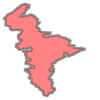

In [14]:

# Save the watershed as a geojson and a shapely geometry object
watershed_geojson = geojson.loads(_r.text)
watershed_shapely = shapely.geometry.shape(_r.json())
print(type(watershed_geojson))
watershed_shapely

In [15]:
_x = json.dumps(watershed_geojson)
_url = 'https://watersheds.cci.drexel.edu/api/osigeo/'
_headers = {}
_r = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)
pwr = eval(_r.text)

# Convert to acres
for r, sqm in pwr.items():
    if r == 'str_bank':
        value = sqm / 1609.34
    else:
        value = sqm / 4046.86
    pwr[r] = value

print(pwr)

{'str_bank': 180.24891550872655, 'head_pwr': 24647.87559715807, 'ara_pwr': 11246.710908671266, 'wet_pwr': 569.0086776485991, 'tot_pwr': 28696.807107136152}


In [16]:
# Call the Fast Zonal API with the Watershed Boundary
_x = json.dumps(watershed_geojson)
_url = 'https://watersheds.cci.drexel.edu/api/fzs/'
_headers = {}
_r = requests.post(_url, data = _x , headers= _headers, allow_redirects=True, verify=True)
lulcs = eval(_r.text)

# Convert to acres
lu_total = 0
for lulc, sqm in lulcs.items():
    value = sqm / 4046.86
    lulcs[lulc] = value
    lu_total += value

# Get PWR percents
pwr_percent = {}
for r, acres in pwr.items():
    try:
        value = acres / lu_total * 100
        if value >= 100:
            value = 100
        pwr_percent[r] = value
    except:
        pwr_percent[r] = 0.001
    

In [17]:
# Show the polygon and its watershed on a new map
zoom_level = round((-0.697 * np.log(lu_total)) + 18.003)

displaymap2 = Map(center = (watershed_shapely.centroid.coords[0][1], watershed_shapely.centroid.coords[0][0])
                 , min_zoom = 1, max_zoom = 20, scroll_wheel_zoom = True,
    basemap=basemaps.Esri.WorldStreetMap)

zoom_slider2 = IntSlider(description='Zoom level:', min=0, max=20, value=zoom_level)
jslink((zoom_slider2, 'value'), (displaymap2, 'zoom'))
widget_control2 = WidgetControl(widget=zoom_slider2, position='topright')

watershed = GeoJSON(
    data=watershed_geojson,
    style={
        'opacity': 1, 'dashArray': '2', 'fillOpacity': 0.2, 'weight': 1, 'color': 'blue'
    }
)

polygon = GeoJSON(
    data=last_geom,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 2, 'color': 'green'
    }
)

measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)

displaymap2.add_control(measure)

measure.completed_color = 'red'

measure.add_length_unit('yards', 1.09361, 4)
measure.secondary_length_unit = 'yards'

measure.add_area_unit('sqyards', 1.19599, 4)
measure.secondary_area_unit = 'sqyards'

displaymap2.add_layer(polygon)
displaymap2.add_layer(watershed)
displaymap2.add_control(widget_control2)


Total Acres: 38274.12
Stream Bank (mi): 180.25
Headwaters (ac): 24647.88
Active River Area (ac): 11246.71
Wetlands (ac): 643.39
Total Priority Water Resources (PWR) (ac): 28696.81


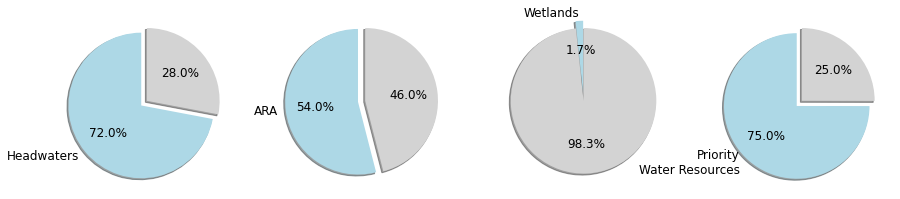

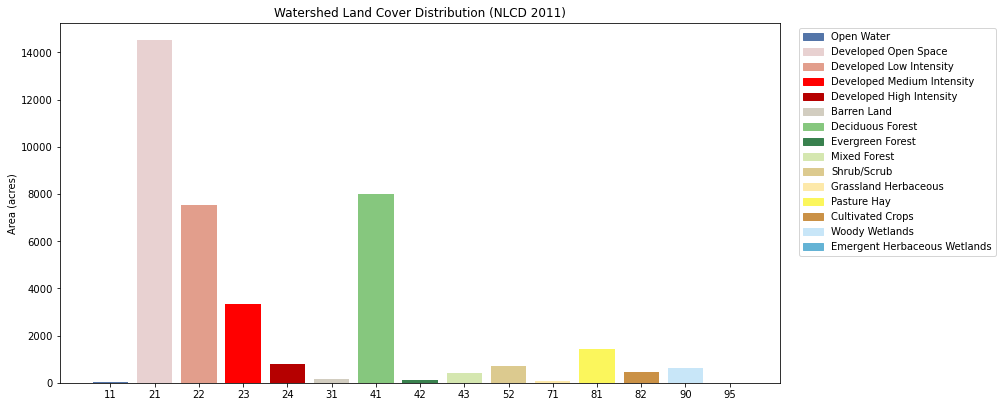

Map(center=[40.13623096856189, -75.21732913510124], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [18]:
# nbi:hide_in
############################
# FINAL VISUALIZATION PAGE #
############################

# Show land cover summary
print('Total Acres: {}'.format(round(lu_total,2)))
# for lulc, sqm in lulcs.items():
#     print('{}: {}'.format(lulc, round(sqm,2)), end =", ")

# Show PWR summary, use the wetlands from the landcover call
pwr_labels = {'str_bank': 'Stream Bank (mi)', 'head_pwr': 'Headwaters (ac)', 'ara_pwr': 'Active River Area (ac)'
              , 'wet_pwr': 'Wetlands (ac)', 'tot_pwr': 'Total Priority Water Resources (PWR) (ac)'}
wetlands_acres = 0.0
for lulc, acre in lulcs.items():
    if lulc == '90' or lulc == '95':
        wetlands_acres += acre
if wetlands_acres > 0.0:
    wetlands_percent = wetlands_acres / lu_total * 100
else:
    wetlands_percent = 0.0

for r, sqm in pwr.items():
    if r == 'wet_pwr':
        print('{}: {}'.format(pwr_labels[r], round(wetlands_acres,2)))
    else:
        print('{}: {}'.format(pwr_labels[r], round(sqm,2)))

###############################
# Pie charts for the PWR call #
###############################

labels_head = 'Headwaters', ''
sizes_head = [pwr_percent['head_pwr'], 100 - pwr_percent['tot_pwr']]

labels_ara = 'ARA', ''
sizes_ara = [pwr_percent['ara_pwr'], 100 - pwr_percent['tot_pwr']]

labels_wet = 'Wetlands', ''
sizes_wet = [wetlands_percent, 100 - wetlands_percent]

labels_pwr = 'Priority\nWater Resources', ''
sizes_pwr = [pwr_percent['tot_pwr'], 100 - pwr_percent['tot_pwr']]

explode = (0.1, 0.0)  # only "explode" the 1st slice
pie_colors = ["lightblue", "lightgrey"]

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig1.set_size_inches(15,15)

ax1.pie(sizes_head, explode=explode, labels=labels_head, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax2.pie(sizes_ara, explode=explode, labels=labels_ara, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax3.pie(sizes_wet, explode=explode, labels=labels_wet, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

ax4.pie(sizes_pwr, explode=explode, labels=labels_pwr, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = pie_colors, textprops={'fontsize': 12})

plt.show()

##########################
# Create Land Cover Plot #
##########################

plot_length = int(len(lulcs))
if plot_length > 10:
    plot_length = 10

fig2 = plt.figure()
fig2.set_size_inches(plot_length,5)
ax2 = fig2.add_axes([0,0,1,1])

colormap = {'11': '#5475a8','21': '#e8d1d1','22': '#e29e8c','23': '#ff0000','24': '#b50000','31': '#d2cdc0',
            '41': '#86c77e','42': '#39814e','43': '#d5e7b0','52': '#dcca8f','71': '#fde9aa','81': '#fbf65c',
            '82': '#ca9146','90': '#c8e6f8','95': '#64b3d5'}

crosswalk = {'11': 'Open Water',
             '21': 'Developed Open Space',
             '22': 'Developed Low Intensity',
             '23': 'Developed Medium Intensity',
             '24': 'Developed High Intensity',
             '31': 'Barren Land',
             '41': 'Deciduous Forest',
             '42': 'Evergreen Forest',
             '43': 'Mixed Forest',
             '52': 'Shrub/Scrub',
             '71': 'Grassland Herbaceous',
             '81': 'Pasture Hay',
             '82': 'Cultivated Crops',
             '90': 'Woody Wetlands',
             '95': 'Emergent Herbaceous Wetlands'}

colors = {x: colormap[x] for x in lulcs}
x_labels = {x: crosswalk[x] for x in lulcs}

ax2.bar(list(lulcs.keys()), list(lulcs.values()), align='center', color=colors.values())
#ax.set_xticklabels(x_labels.values())
ax2.set_ylabel('Area (acres)')
ax2.set_title('Watershed Land Cover Distribution (NLCD 2011)')
handles = [plt.Rectangle((0,0),len(lulcs),len(lulcs), color=colors[label]) for label in x_labels]
ax2.legend(handles, x_labels.values(), bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

################
# Show the map #
################

displaymap2

In [19]:
# nbi:hide_in